In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold,GridSearchCV,train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, classification_report,roc_curve, auc, precision_recall_curve, average_precision_score

In [8]:
# Load and process data
df = pd.read_csv("leetcode_questions_processed1.csv")
df = df.drop(columns=['frontend_id', 'slug'], errors='ignore')
df = df.sort_values('question_id')

# Encode topic tags
df_encoded = df['topic_tags'].str.get_dummies(sep=', ')
df_final = pd.concat([df.drop(columns=['topic_tags']), df_encoded], axis=1)

# Clean and filter data
df_final = df_final[
    df_final['problem_statement'].notna() &
    (df_final['problem_statement'].str.strip() != '')
].copy()

print(f"Multi-hot Encoded DataFrame Dimensions: {df_final.shape}")
print(df_final.head().to_string(index=False))

Multi-hot Encoded DataFrame Dimensions: (2751, 79)
 question_id                                          title                                                                                                                                                                                                                                                                                                              problem_statement difficulty   category  ac_rate  total_accepted  total_submissions  Array  Backtracking  Biconnected Component  Binary Indexed Tree  Binary Search  Binary Search Tree  Binary Tree  Bit Manipulation  Bitmask  Brainteaser  Breadth-First Search  Bucket Sort  Combinatorics  Concurrency  Counting  Counting Sort  Data Stream  Database  Depth-First Search  Design  Divide and Conquer  Doubly-Linked List  Dynamic Programming  Enumeration  Eulerian Circuit  Game Theory  Geometry  Graph  Greedy  Hash Function  Hash Table  Heap (Priority Queue)  Interactive  Iterator  Line Swe

Difficulty Distribution
difficulty
Medium    1383
Easy       736
Hard       632
Name: count, dtype: int64


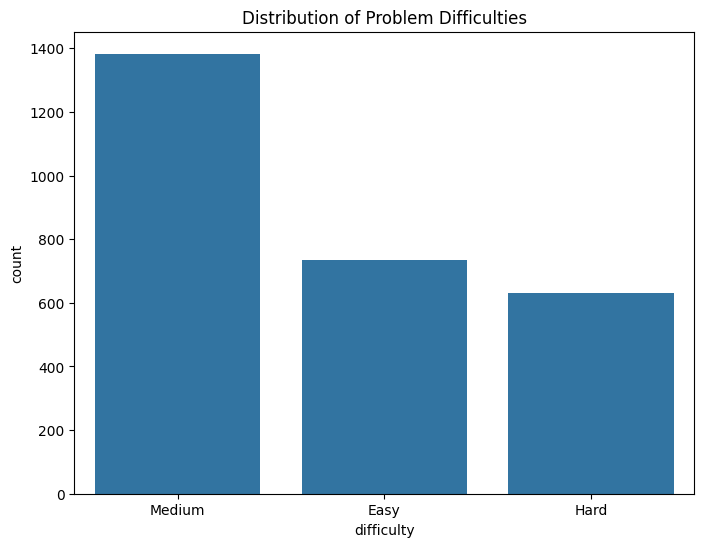

Category Distribution
category
Algorithms     2607
Database         82
JavaScript       37
pandas           15
Concurrency       6
Shell             4
Name: count, dtype: int64


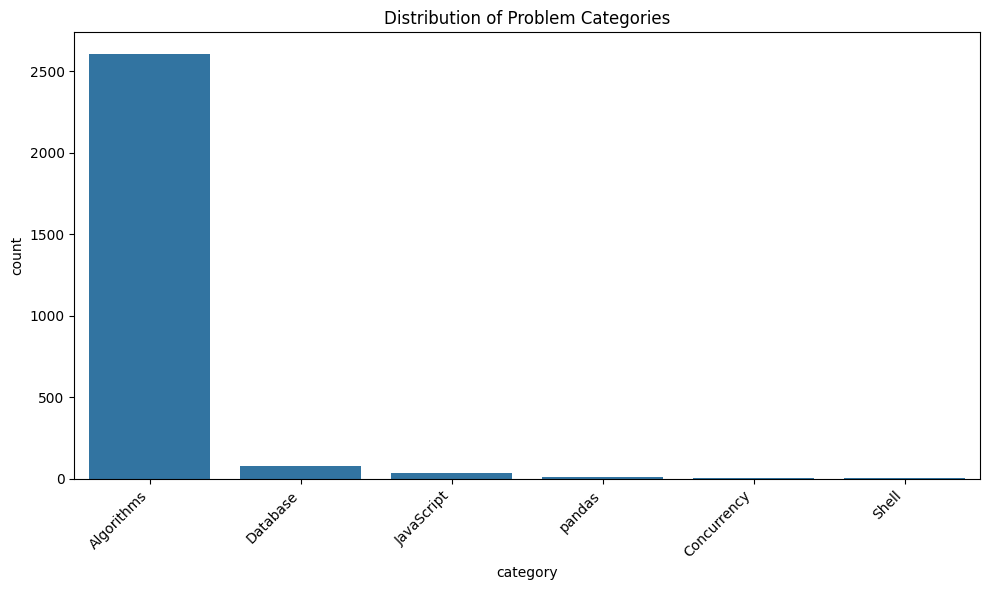

Tag Frequency Analysis
Array                           1575
String                           661
Hash Table                       564
Dynamic Programming              491
Math                             488
                                ... 
Eulerian Circuit                   3
Strongly Connected Component       3
Rejection Sampling                 2
Minimum Spanning Tree              2
Biconnected Component              1
Length: 71, dtype: int64


<ipython-input-9-227aebb24492>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tag_counts.values, y=top_tag_counts.index, palette="viridis")


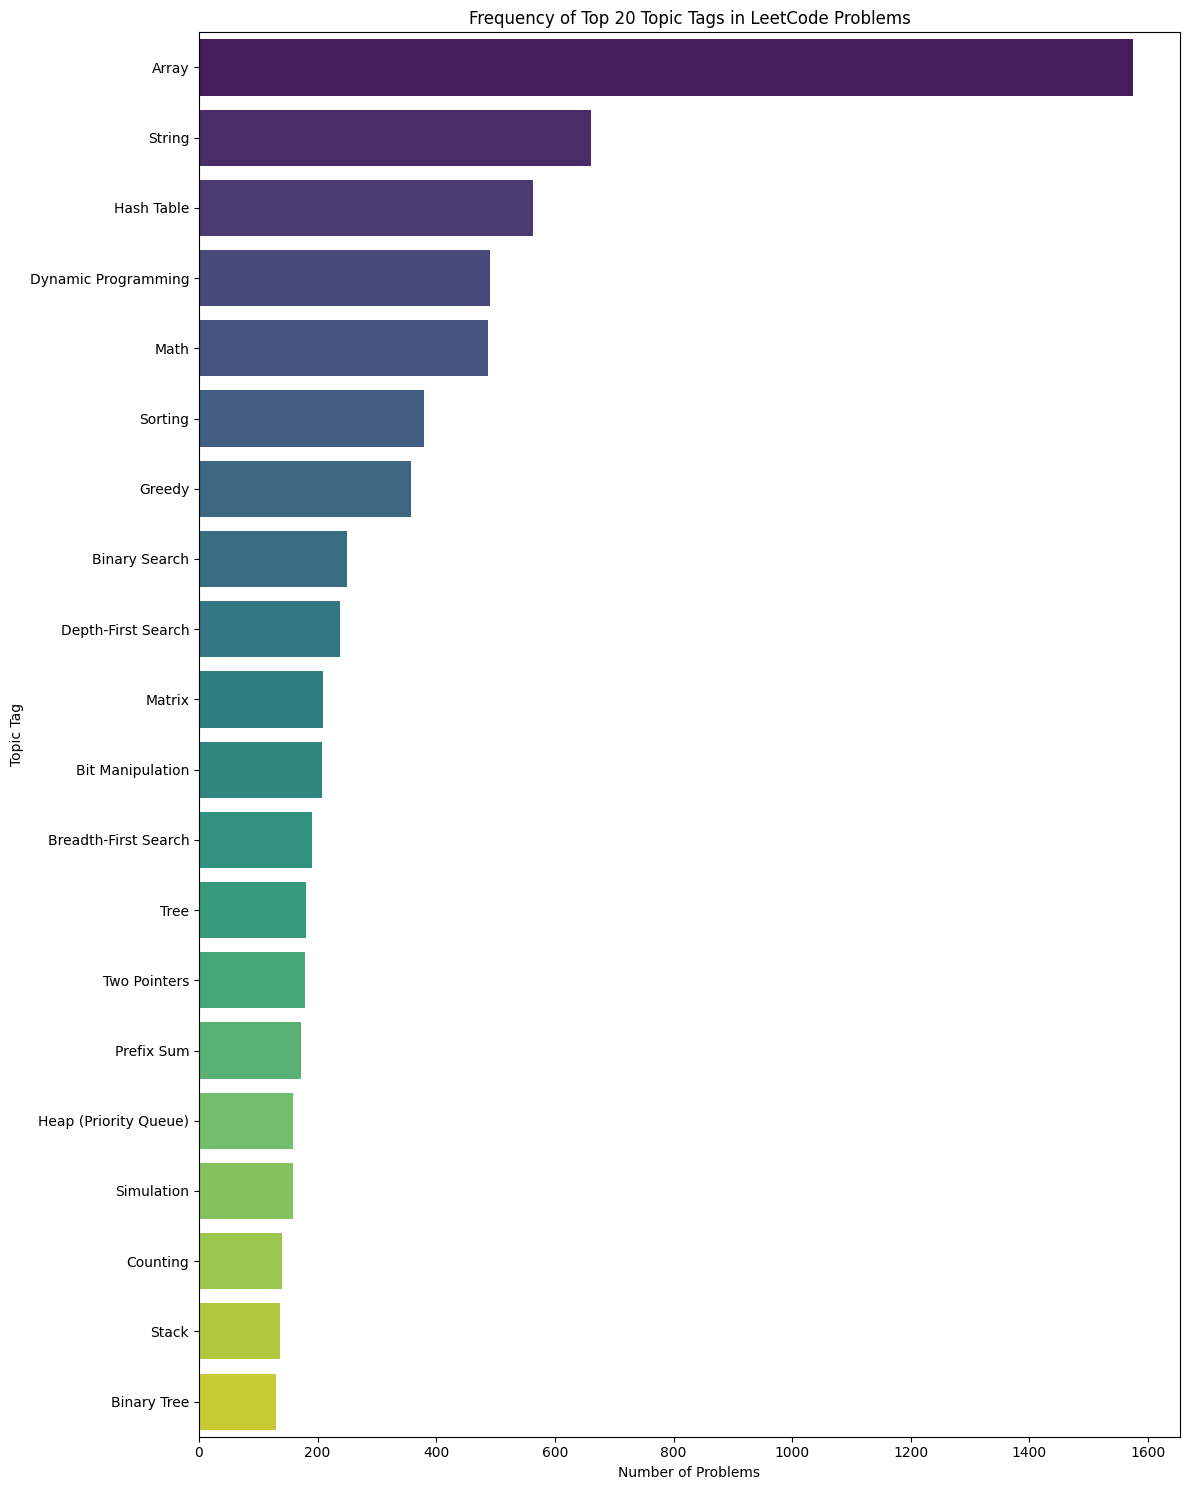

Difficulty vs. Acceptance Rate


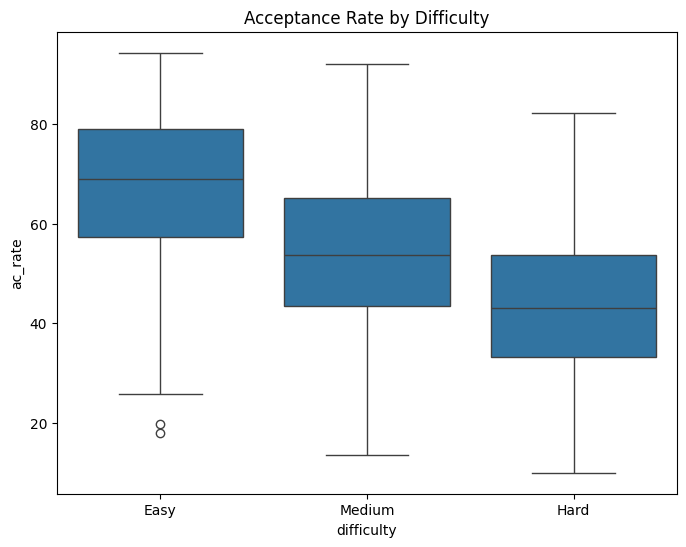

Category vs. Acceptance Rate


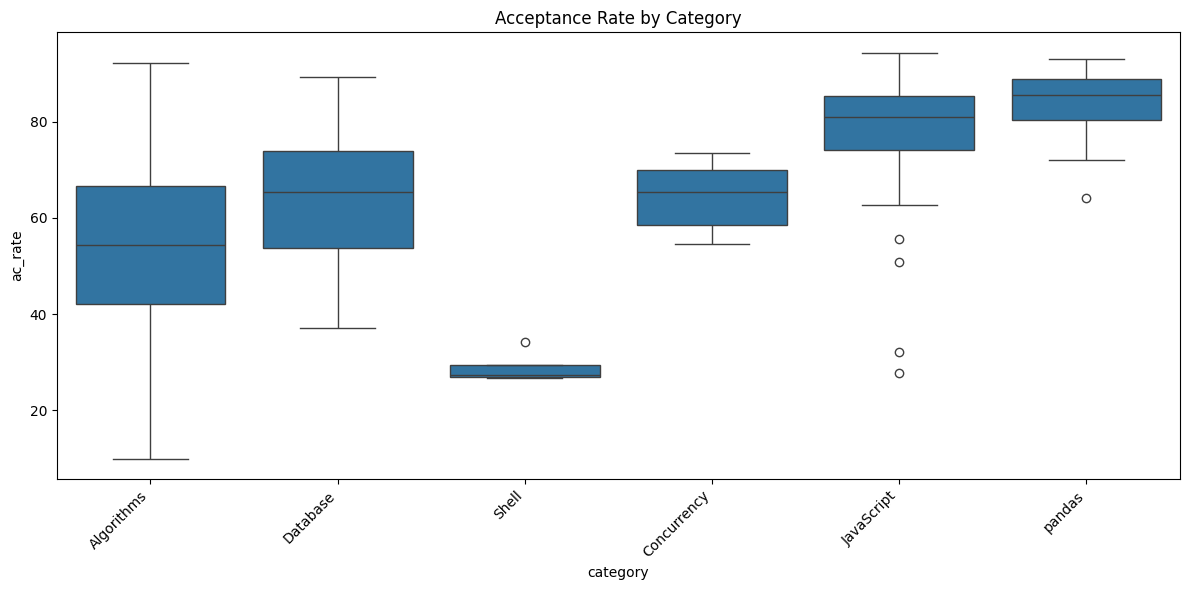

In [9]:
print("Difficulty Distribution")
difficulty_counts = df_final['difficulty'].value_counts()
print(difficulty_counts)

plt.figure(figsize=(8, 6))
sns.countplot(data=df_final, x='difficulty', order=df_final['difficulty'].value_counts().index)
plt.title('Distribution of Problem Difficulties')
plt.show()

# 2. Category Distribution
print("Category Distribution")
category_counts = df_final['category'].value_counts()
print(category_counts)
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='category', order=df_final['category'].value_counts().index)
plt.title('Distribution of Problem Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Tag Frequency Analysis
print("Tag Frequency Analysis")
tag_counts = df_final.iloc[:, 8:].sum().sort_values(ascending=False)
print(tag_counts)
plt.figure(figsize=(12, 15))
num_tags_to_plot = 20
top_tag_counts = tag_counts.head(num_tags_to_plot)
sns.barplot(x=top_tag_counts.values, y=top_tag_counts.index, palette="viridis")
plt.title(f'Frequency of Top {num_tags_to_plot} Topic Tags in LeetCode Problems')
plt.xlabel('Number of Problems')
plt.ylabel('Topic Tag')
plt.tight_layout()
plt.show()

# 5. Difficulty vs. Acceptance Rate
print("Difficulty vs. Acceptance Rate")
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_final, x='difficulty', y='ac_rate')
plt.title('Acceptance Rate by Difficulty')
plt.show()

# 6. Category vs. Acceptance Rate
print("Category vs. Acceptance Rate")
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_final, x='category', y='ac_rate')
plt.title('Acceptance Rate by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Correlation Heatmap 
                    ac_rate  total_accepted  total_submissions
ac_rate            1.000000        0.105316           0.007060
total_accepted     0.105316        1.000000           0.964751
total_submissions  0.007060        0.964751           1.000000


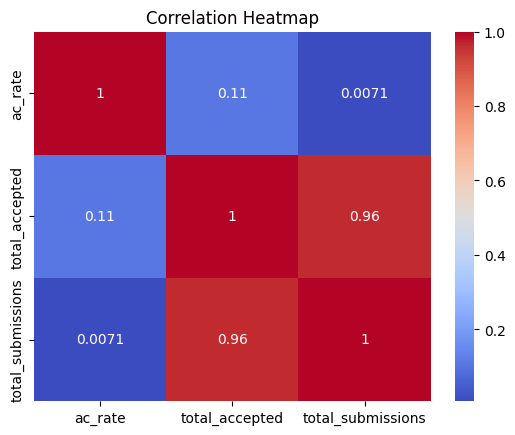

Total Accepted Distribution


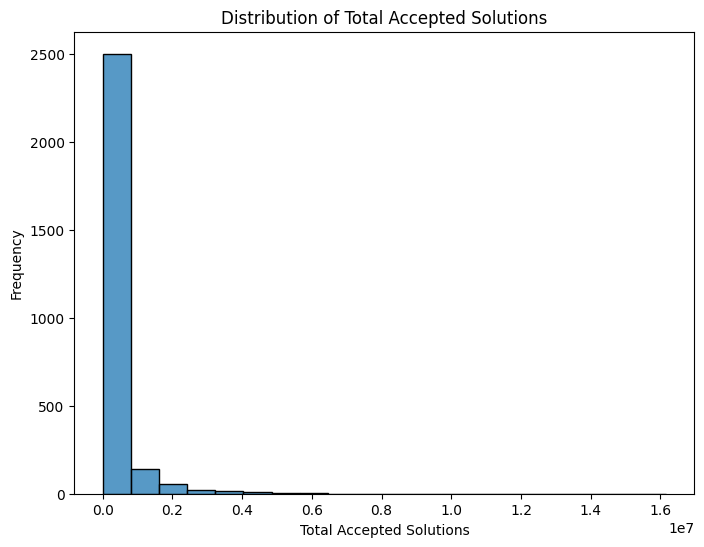

Total Submissions Distribution


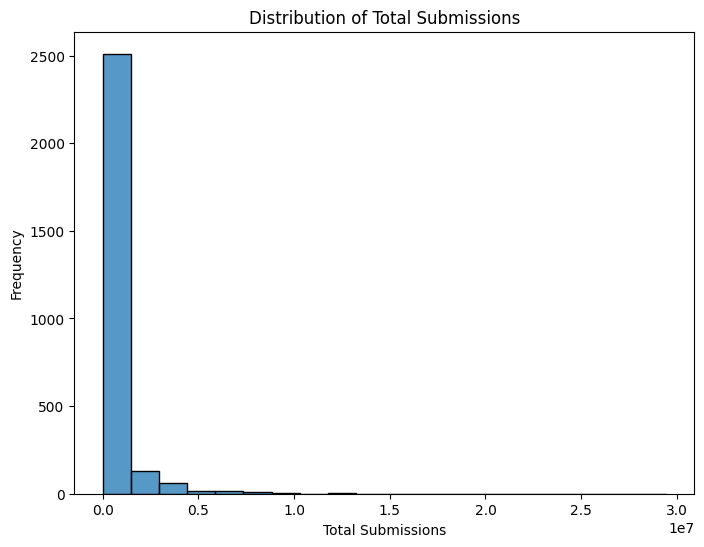

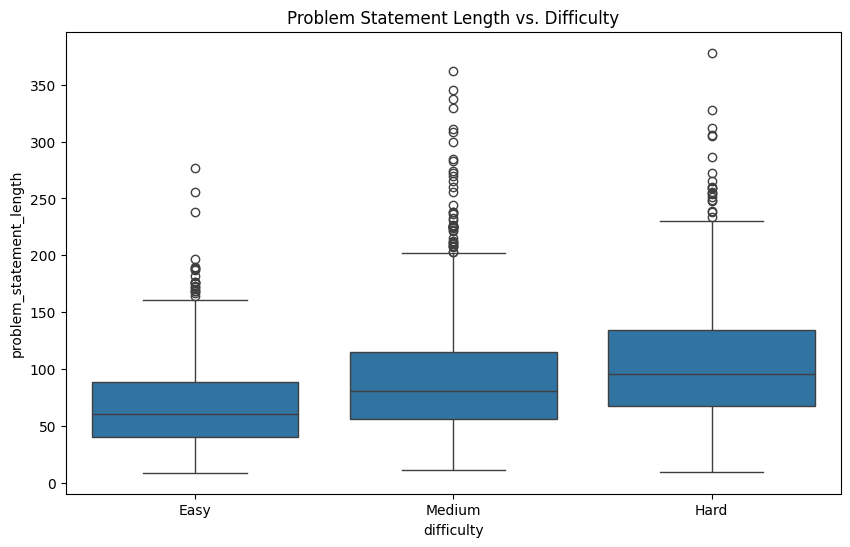

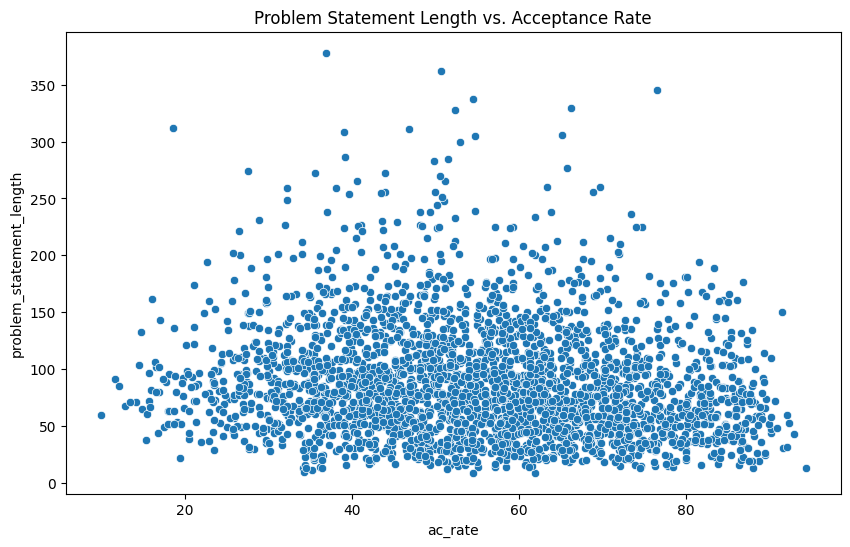

Cross-tabulation of Category and Difficulty:
difficulty   Easy  Hard  Medium
category                       
Algorithms    645   625    1337
Concurrency     1     0       5
Database       52     5      25
JavaScript     21     2      14
Shell           2     0       2
pandas         15     0       0


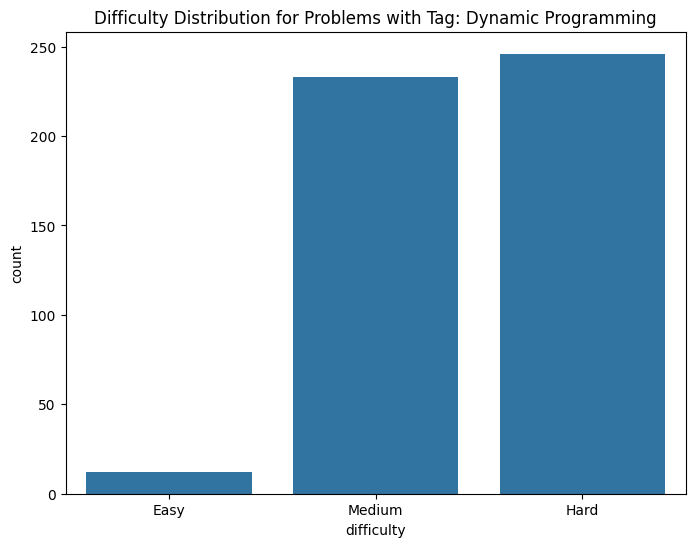

In [10]:
# 7. Correlation between Difficulty and Total Submissions/Accepted
print("Correlation Heatmap ")
correlation = df_final[['ac_rate', 'total_accepted', 'total_submissions']].corr()
print(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# 9. Additional: Analyze the distribution of total_accepted and total_submissions.
print("Total Accepted Distribution")
plt.figure(figsize=(8, 6))
sns.histplot(df_final['total_accepted'], bins=20)
plt.title('Distribution of Total Accepted Solutions')
plt.xlabel('Total Accepted Solutions')
plt.ylabel('Frequency')
plt.show()

print("Total Submissions Distribution")
plt.figure(figsize=(8, 6))
sns.histplot(df_final['total_submissions'], bins=20)
plt.title('Distribution of Total Submissions')
plt.xlabel('Total Submissions')
plt.ylabel('Frequency')
plt.show()

#10 Problem Statement Length vs Difficulty
df_final['problem_statement_length'] = df['problem_statement'].astype(str).apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.boxplot(x='difficulty', y='problem_statement_length', data=df_final)
plt.title('Problem Statement Length vs. Difficulty')
plt.show()

#11. Problem Statement Length vs Acceptance Rate
plt.figure(figsize=(10,6))
sns.scatterplot(x='ac_rate', y='problem_statement_length', data=df_final)
plt.title('Problem Statement Length vs. Acceptance Rate')
plt.show()


# 13. Category vs Difficulty
cross_tab = pd.crosstab(df_final['category'], df_final['difficulty'])
print("Cross-tabulation of Category and Difficulty:")
print(cross_tab)


#14 Tag vs. Difficulty - Example
tag = 'Dynamic Programming'
plt.figure(figsize=(8, 6))
sns.countplot(data=df_final[df_final[tag] == 1], x='difficulty', order=['Easy', 'Medium', 'Hard'])
plt.title(f'Difficulty Distribution for Problems with Tag: {tag}')
plt.show()

In [11]:
difficulty_map = {'Easy': 0, 'Medium': 1, 'Hard': 2}
df_final['difficulty'] = df_final['difficulty'].map(difficulty_map)

# Balance classes
easy = df_final[df_final['difficulty'] == 0]
medium = df_final[df_final['difficulty'] == 1]
hard = df_final[df_final['difficulty'] == 2]

undersampled = medium.sample(n=len(easy), random_state=42)
df_balanced = pd.concat([easy,undersampled, hard], axis=0).sample(frac=1, random_state=42)

# Drop irrelevant columns
df_balanced = df_balanced.drop(columns=['question_id', 'title','category'], errors='ignore')
print("Balanced class distribution:")
print(df_balanced['difficulty'].value_counts())

Balanced class distribution:
difficulty
1    736
0    736
2    632
Name: count, dtype: int64


In [12]:
X = df_balanced.drop(columns=['difficulty'])
y = df_balanced['difficulty']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [13]:
numerical_cols = ['ac_rate', 'total_accepted', 'total_submissions', 'problem_statement_length']

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols])
X_test_num = scaler.transform(X_test[numerical_cols])

In [14]:
tfidf = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=20,
    max_df=0.9
)
X_train_text = tfidf.fit_transform(X_train['problem_statement'])
X_test_text = tfidf.transform(X_test['problem_statement'])


tag_cols = [col for col in X_train.columns if col not in numerical_cols + ['problem_statement']]

X_train_tags = X_train[tag_cols].values
X_test_tags = X_test[tag_cols].values

# Combine all features
X_train_combined = hstack([X_train_num, X_train_tags, X_train_text], format='csr')
X_test_combined = hstack([X_test_num, X_test_tags, X_test_text], format='csr')

In [15]:
X_train_full = X_train_combined
X_train_dense = X_train_combined.toarray()
X_test_dense = X_test_combined.toarray()

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

models = [
    {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'sag']
        },
        'dense': False
    },

    {
    'name': 'Random Forest',
    'estimator': RandomForestClassifier(random_state=42),
    'params': {
        'n_estimators': [50],
        'max_depth': [5,6,7,8],
        'min_samples_leaf': [3],
    },
    'dense': True
    }   ,
    {
        'name': 'KNN',
        'estimator': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2],
            'metric': ['cosine', 'manhattan', 'euclidean']
        },
        'dense': True
    },
    {
        'name': 'XGBoost',
        'estimator': XGBClassifier(tree_method='hist', random_state=42),
        'params': {
            'learning_rate': [0.05, 0.01],
            'max_depth': [3, 5],
        },
        'dense': True
    },
]


for model_config in models:
    print(f"\n{'='*60}")
    print(f"Training {model_config['name']}")
    print(f"{'='*60}")


    if model_config['dense']:
        X_train_model = X_train_dense
        X_test_model = X_test_dense
    else:
        X_train_model = X_train_full
        X_test_model = X_test_combined

    grid = GridSearchCV(
        estimator=model_config['estimator'],
        param_grid=model_config['params'],
        cv=cv1,
        scoring='accuracy',
        n_jobs=2
    )
    grid.fit(X_train_model, y_train)

    train_pred = grid.best_estimator_.predict(X_train_model)
    test_pred = grid.best_estimator_.predict(X_test_model)

    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    print(f"Best Parameters: {grid.best_params_}")
    print(f"Training Accuracy: {train_acc:.2%}")
    print(f"Test Accuracy: {test_acc:.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, test_pred))




Training Logistic Regression
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Accuracy: 79.50%
Test Accuracy: 66.98%

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       147
           1       0.56      0.50      0.53       147
           2       0.64      0.67      0.66       127

    accuracy                           0.67       421
   macro avg       0.66      0.67      0.66       421
weighted avg       0.66      0.67      0.67       421


Training Random Forest
Best Parameters: {'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 50}
Training Accuracy: 72.61%
Test Accuracy: 67.93%

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.85      0.76       147
           1       0.57      0.55      0.56       147
           2       0.82      0.63      0.71       127

    accuracy                           0.68       421
   macro a

In [16]:
# Retrain models with optimal parameters
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=8,
    min_samples_leaf=3,
    random_state=42
).fit(X_train_dense, y_train)

xgb_model = XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    random_state=42
).fit(X_train_dense, y_train)

In [17]:
# Predictions
y_pred_rf = rf_model.predict(X_test_dense)
y_pred_xgb = xgb_model.predict(X_test_dense)

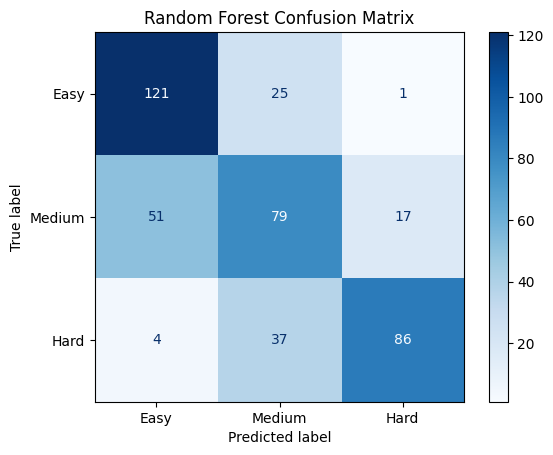

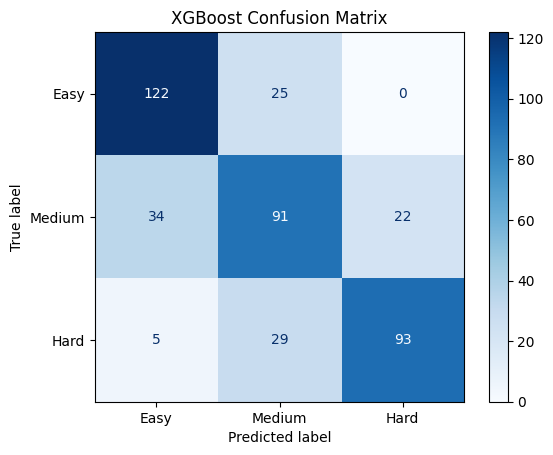

In [18]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['Easy', 'Medium', 'Hard']
    )
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost Confusion Matrix')

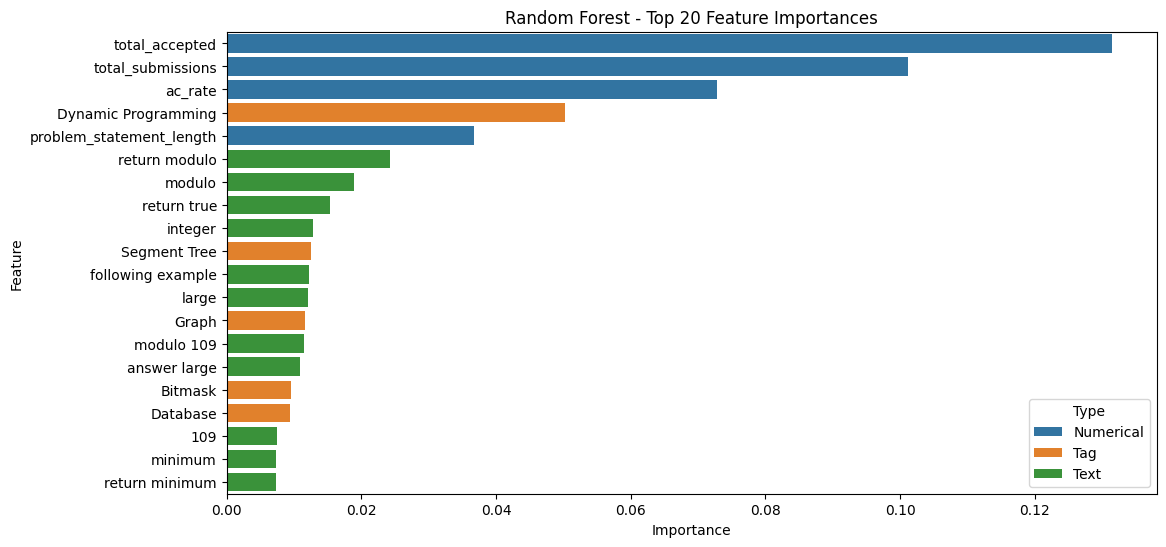

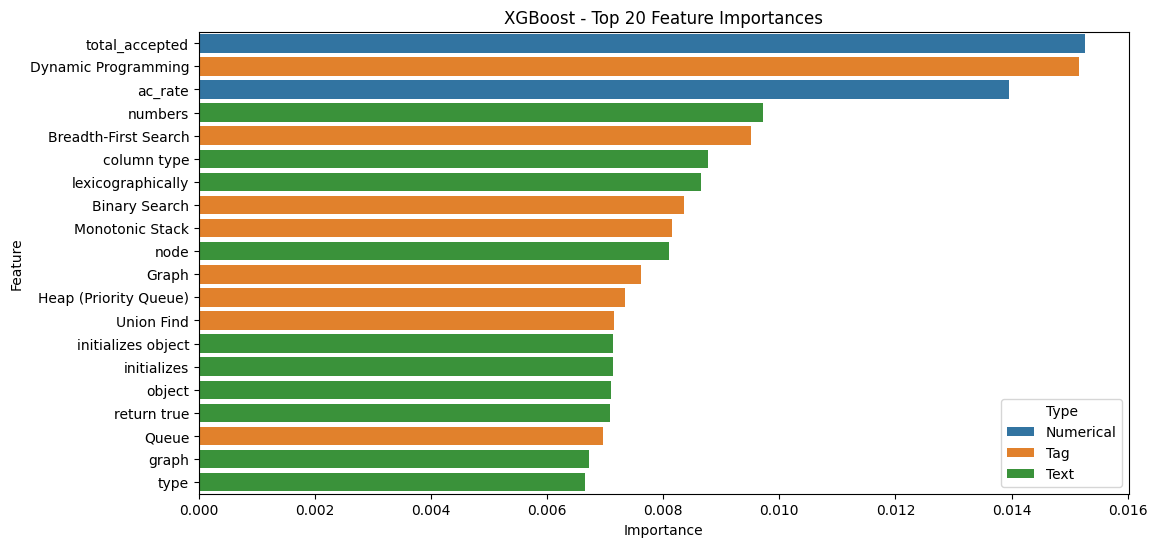

In [20]:
feature_names = numerical_cols + tag_cols + list(tfidf.get_feature_names_out())

def plot_feature_importance(importances, title, top_n=20):
    features_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    features_df = features_df.sort_values('Importance', ascending=False).head(top_n)

    features_df['Type'] = 'Text'
    features_df.loc[features_df['Feature'].isin(numerical_cols), 'Type'] = 'Numerical'
    features_df.loc[features_df['Feature'].isin(tag_cols), 'Type'] = 'Tag'

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', hue='Type', data=features_df, dodge=False)
    plt.title(title)
    plt.show()

# Random Forest
plot_feature_importance(
    rf_model.feature_importances_,
    'Random Forest - Top 20 Feature Importances'
)

# XGBoost
plot_feature_importance(
    xgb_model.feature_importances_,
    'XGBoost - Top 20 Feature Importances'
)

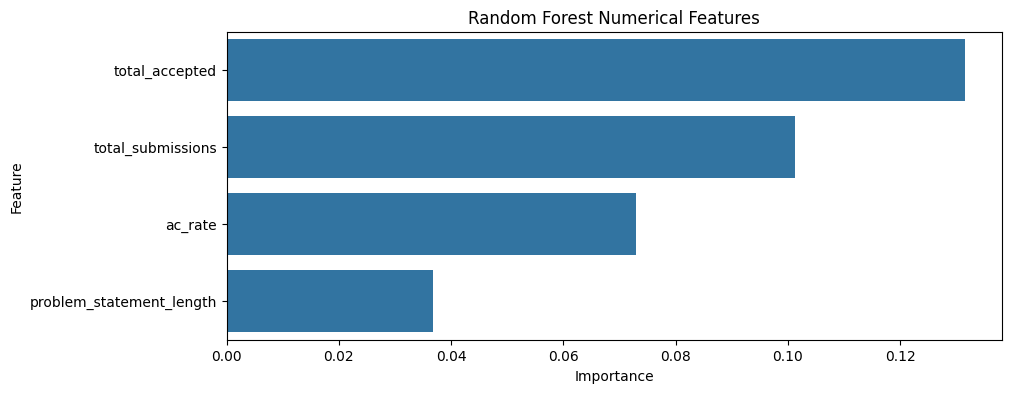

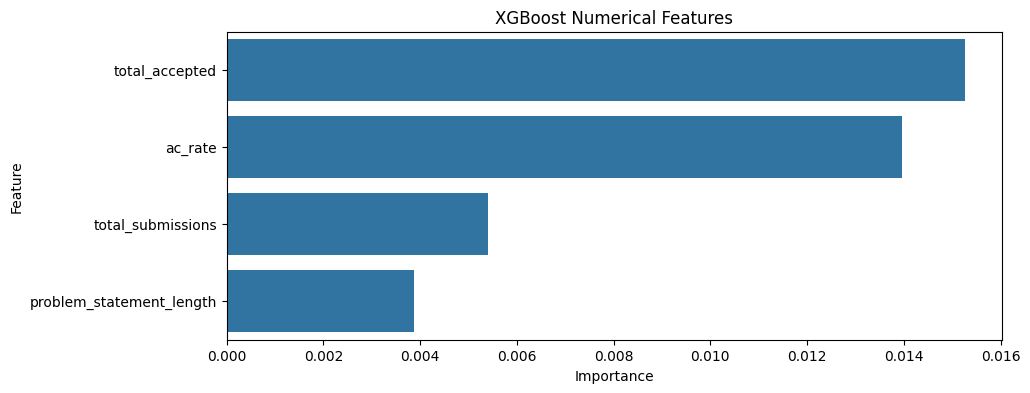

In [21]:
def plot_numerical_importance(importances, title):
    num_df = pd.DataFrame({
        'Feature': numerical_cols,
        'Importance': importances[:len(numerical_cols)]
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 4))
    sns.barplot(x='Importance', y='Feature', data=num_df)
    plt.title(title)
    plt.show()

plot_numerical_importance(rf_model.feature_importances_, 'Random Forest Numerical Features')
plot_numerical_importance(xgb_model.feature_importances_, 'XGBoost Numerical Features')

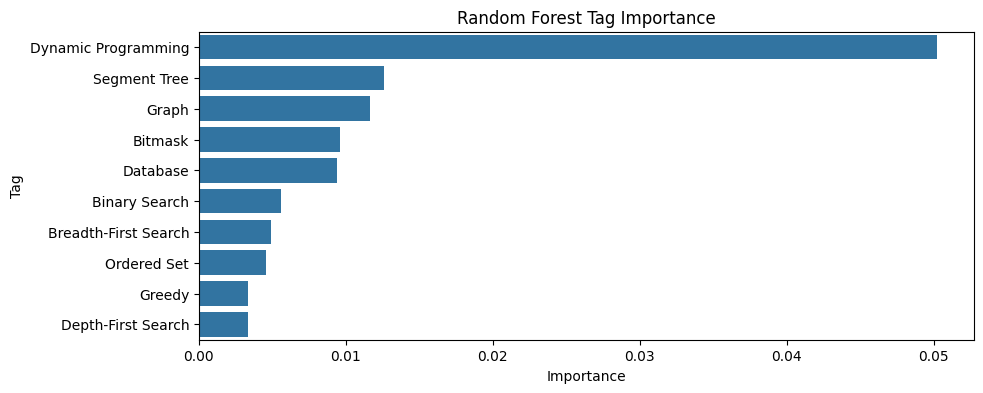

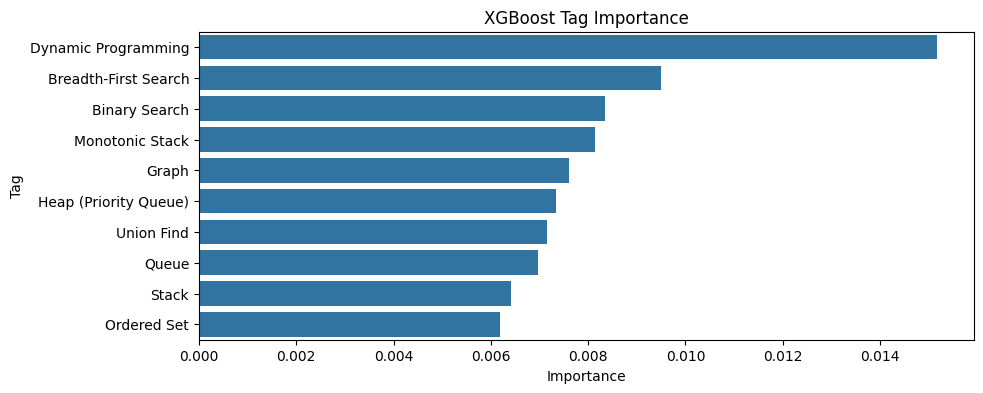

In [22]:
def plot_tag_importance(importances, title):
    tag_importances = importances[len(numerical_cols):len(numerical_cols)+len(tag_cols)]
    tag_df = pd.DataFrame({
        'Tag': tag_cols,
        'Importance': tag_importances
    }).sort_values('Importance', ascending=False).head(10)

    plt.figure(figsize=(10, 4))
    sns.barplot(x='Importance', y='Tag', data=tag_df)
    plt.title(title)
    plt.show()

plot_tag_importance(rf_model.feature_importances_, 'Random Forest Tag Importance')
plot_tag_importance(xgb_model.feature_importances_, 'XGBoost Tag Importance')

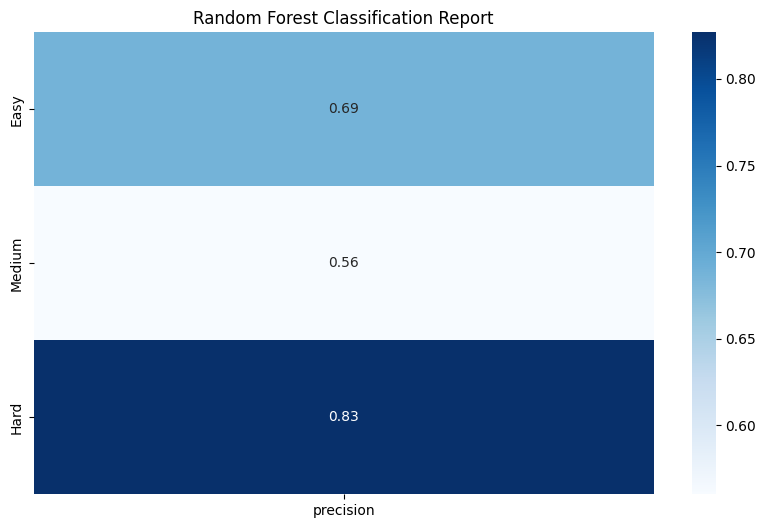

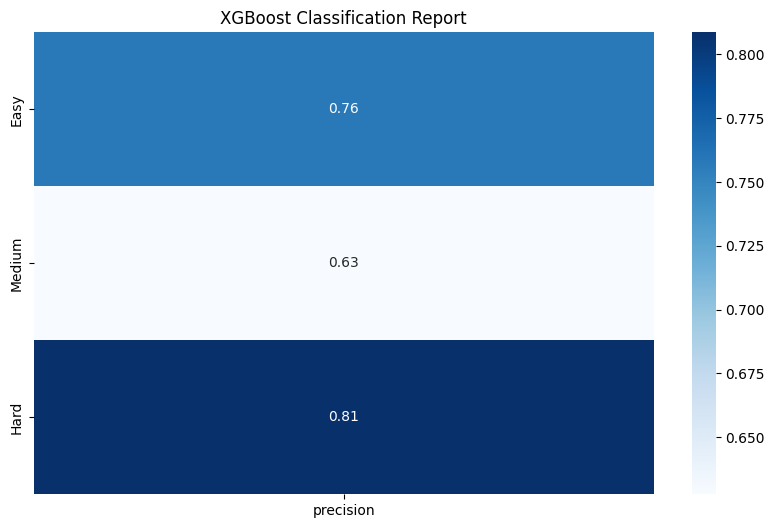

In [23]:
def plot_classification_report(y_true, y_pred, title):
        report = classification_report(y_true, y_pred, target_names=['Easy', 'Medium', 'Hard'], output_dict=True)
        report_df = pd.DataFrame(report).iloc[:-3, :3].T

        plt.figure(figsize=(10, 6))
        sns.heatmap(report_df, annot=True, cmap='Blues', fmt=".2f")
        plt.title(title)
        plt.show()

plot_classification_report(y_test, y_pred_rf, 'Random Forest Classification Report')
plot_classification_report(y_test, y_pred_xgb, 'XGBoost Classification Report')

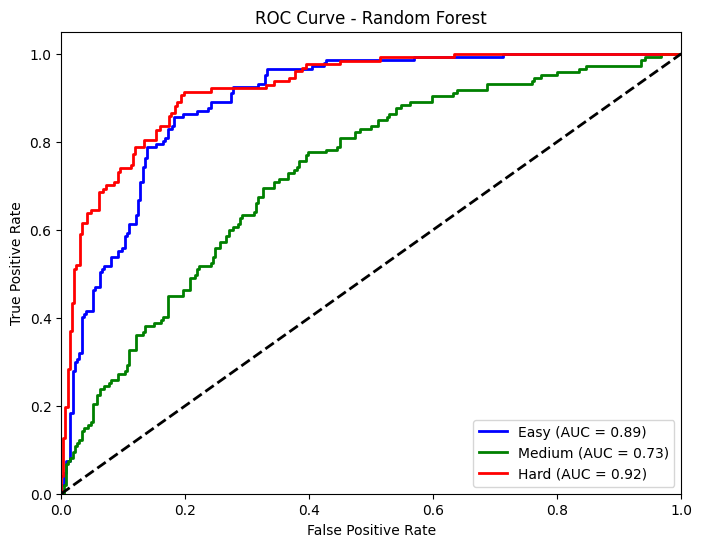

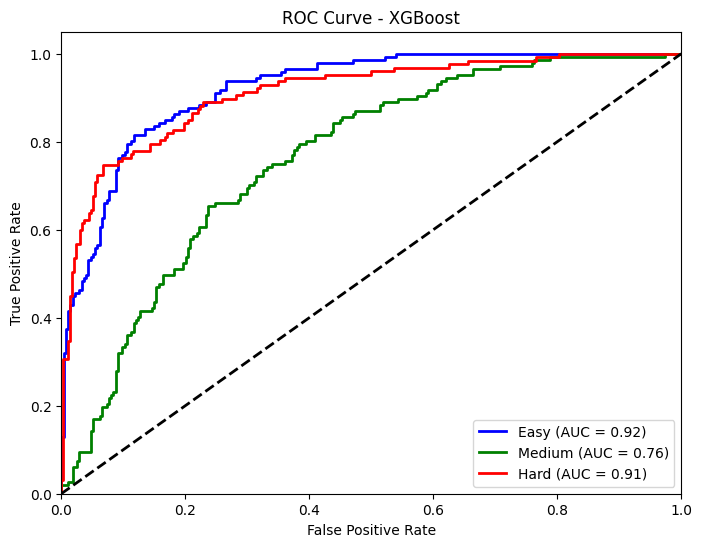

In [26]:
y_probs_rf = rf_model.predict_proba(X_test_dense)
y_probs_xgb = xgb_model.predict_proba(X_test_dense)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

class_names = ['Easy', 'Medium', 'Hard']
classes = [0, 1, 2]

def plot_roc_curve(y_true, y_probs, model_name):
    y_true_bin = label_binarize(y_true, classes=classes)

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red']
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_test, y_probs_rf, 'Random Forest')
plot_roc_curve(y_test, y_probs_xgb, 'XGBoost')

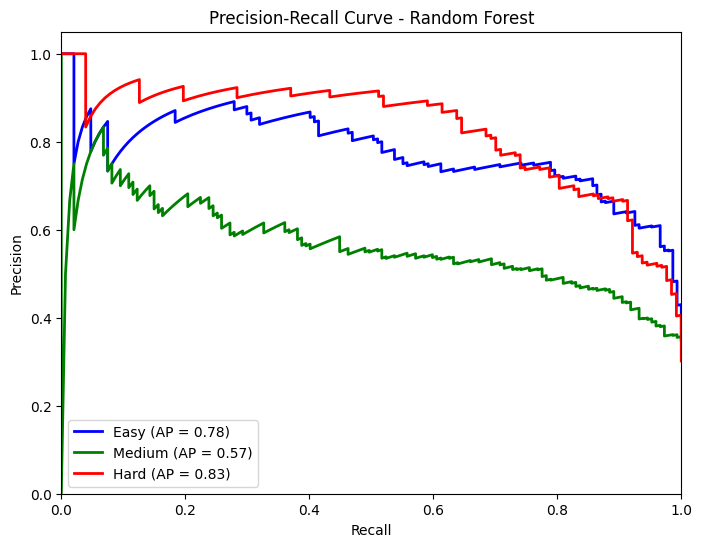

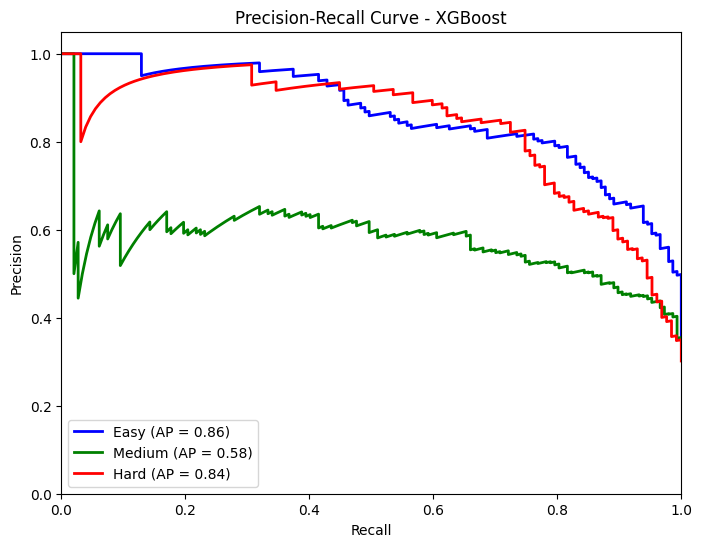

In [27]:
def plot_pr_curve(y_true, y_probs, model_name):
    y_true_bin = label_binarize(y_true, classes=classes)

    precision, recall, avg_precision = {}, {}, {}
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        avg_precision[i] = average_precision_score(y_true_bin[:, i], y_probs[:, i])

    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red']
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'{class_names[i]} (AP = {avg_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc='lower left')
    plt.show()

plot_pr_curve(y_test, y_probs_rf, 'Random Forest')
plot_pr_curve(y_test, y_probs_xgb, 'XGBoost')